# Hello! Thank you for visiting this notebook. 

## The major sections are as follows:

- ## 1. Introduction
    - ##### What is the goal?
    - ##### Where did the data come from?
    - ##### What is the unit of analysis?
- ## 2. File reading
    - ##### Reading in source files.
- ## 3. Calculate descriptive statistics for perceived usefulness
    - ##### Generate CardTable 
    - ##### Calculate perceived usefulness scores
    - ##### Visualize the proportions in perceived usefulness scores
    - ##### Compute the correlation distance based on the perceived usefulness scores
    - ##### Determine the number of clusters for perceived usefulness scores
    - ##### Cluster the information cards based on correlation distance
    - ##### Combine the perceived usefulness scores stacked barchart with the clustergram
- ## 4. Examine patterns in Use-case discussions
    - ##### Count number of participants that discussed each use-case 
    - ##### Calculate the correlation distance between information use-case discussions
    - ##### Determine the number of clusters for the information use-case discussions
    - ##### Clusters the use-case discussions
    - ##### Extract the top 15 information use-cases discussed

# 1. Introduction

- ### What is the goal?
This Jupyter notebook was created to generate descriptive statistics and cluster analysis of card sorting matrices. The objective is to establish a pilot analysis protocol for mixed method study of information use and insight for integration of population health researchers with hurricane and flood disaster preparedness.

- ### Where did the data come from?
The primary data set was collected through 1-on-1 audio-recorded sessions with study participants (population health researchers). Each session is comprised of semi-structured interview and think-aloud card sorting activity. Here, we focus on the card sorting activity of each session. Participants were briefly introduced to a set of 31 hurricane and flood information cards and asked to think-aloud as they sorted them into groups based on what they perceived as **"useful"**, **"maybe" useful**, and **"not" useful** for their research. Then, participants discussed their **"useful"** and **"maybe" useful** cards to consider priority order and intuitive groupings of cards for use in research. Finally, we asked participants what other information concept would be useful to collect for use in research, which received a usefulness rating of "addition". Card sorting sessions were transcribed to text and thematic analysis coded for information use-cases discussed by participants.

- ### What is the unit of analysis?
We applied the information use-cases to understand the perceived contexts for how information products can be used for research in population health. Each card sorting session was summarized as a single matrix and analyzed as a unit of analysis. Each matrix is stored as a spreadsheet within an Excel workbook.

# 2. File reading

- ### Reading in source files.

    First we read and extract the matrix portion of the spreadsheet into a dataframe. Then, we append them into the listOfMatrices object, which is a list of dataframes to automate further extractions. The function **xlsx_extract** will help automate these operations.

In [1]:
""" Initialize the libraries """

import os, glob
import pandas as pd
import numpy as np

# Visual and network
import seaborn as sb
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# statistical testing
from statsmodels.stats.contingency_tables import Table2x2
from scipy.stats import fisher_exact
from statsmodels.stats import multitest as smm

# clustering functions
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, ward, cut_tree

In [2]:
# set file source
xls_file = os.path.join(os.getcwd(),'data/data_collection_matrices.xlsx')

# set file output
output = os.path.join(os.getcwd(),'output')

In [3]:
def xlsx_extract(xls_file, xls_sheet, header_rows=3):
    """
    xls_file (dir): the path to the Excel workbook
    xls_sheet (str): the name of the worksheet
    header_rows (int): the number of rows to treat as headers; default to 3 rows based on this template structure
    """
    # connect with the spreadsheet
    xtmp = pd.read_excel(xls_file, sheet_name=xls_sheet, header=None)
    
    # extract headers
    newcols = [list(each) for ind, each in xtmp.iloc[:header_rows,:].fillna('').iterrows()]

    # generate new dataframe
    xout = pd.DataFrame(xtmp.values[header_rows:],
                           index=xtmp.index[header_rows:],
                           columns=newcols)

    # label the column levels and remove the extra column
    xout.columns.names = xout.columns[5]
    xout = xout.drop('UsecaseCode', axis=1)
    return(xout)



# read each matrix
P01 = xlsx_extract(xls_file, xls_sheet = 'P01_cs_raw')
P02 = xlsx_extract(xls_file, xls_sheet = 'P02_cs_raw')
P04 = xlsx_extract(xls_file, xls_sheet = 'P04_cs_raw')
P05 = xlsx_extract(xls_file, xls_sheet = 'P05_cs_raw')
P06 = xlsx_extract(xls_file, xls_sheet = 'P06_cs_raw')
P07 = xlsx_extract(xls_file, xls_sheet = 'P07_cs_raw')
P08 = xlsx_extract(xls_file, xls_sheet = 'P08_cs_raw')
P11 = xlsx_extract(xls_file, xls_sheet = 'P11_cs_raw')
P12 = xlsx_extract(xls_file, xls_sheet = 'P12_cs_raw')
P13 = xlsx_extract(xls_file, xls_sheet = 'P13_cs_raw')
P16 = xlsx_extract(xls_file, xls_sheet = 'P16_cs_raw')
P17 = xlsx_extract(xls_file, xls_sheet = 'P17_cs_raw')
P18 = xlsx_extract(xls_file, xls_sheet = 'P18_cs_raw')
P19 = xlsx_extract(xls_file, xls_sheet = 'P19_cs_raw')
P20 = xlsx_extract(xls_file, xls_sheet = 'P20_cs_raw')

# append to list of matrices
listOfMatrices = [P01, P02, P04, P05, P06, P07, P08, P11, P12, P13, P16, P17, P18, P19, P20]

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


# 3. Calculate descriptive statistics for perceived usefulness
- ### Generate CardTable

    From each matrix, we extract and transform **Information card concept**, **participant ID**, and **perceived usefulness ratings** (referred here as CardUsefulness). The function **matrices_to_CardTable** will iterate and merge data for all dataframes in list to output the **CardTable** object.

In [4]:
def matrices_to_CardTable(Rowlabel, Columnlabel, Valuelabel, listOfMatrices):
    """
    Rowlabel (str): the name of the matrix column to set as row indices
    Columnlabel (str): the name of the matrix column to set as column names
    Valuelabel (str): the name of the matrix column
    """
    # iterate through each item in listOfMatrices
    for eachobj in listOfMatrices:
        if 'mat' not in locals():
            mat = eachobj.pivot_table(index=Rowlabel, columns=Columnlabel, values=Valuelabel, aggfunc=lambda x: x)
        else:
            # merge into output table
            mat = mat.merge(eachobj.pivot_table(index=Rowlabel, columns=Columnlabel, values=Valuelabel, aggfunc=lambda x: x), 
                            left_index=True, right_index=True, how='outer')
            
    # remove duplicated rows
    return(mat.reset_index().drop_duplicates().set_index(Rowlabel))

# generate summary dataframe
CardTable = matrices_to_CardTable(Rowlabel='CardConcept', 
                                  Columnlabel='ParticipantID', 
                                  Valuelabel='CardUsefulness', 
                                  listOfMatrices=listOfMatrices)

# save CardTable
CardTable.reset_index().to_csv(os.path.join(output,'CardUsefulness.csv'), index=False, na_rep='NaN')

# inspect printout
CardTable

ParticipantID,P01,P02,P04,P05,P06,P07,P08,P11,P12,P13,P16,P17,P18,P19,P20
CardConcept,,,,,,,,,,,,,,,
Allied healthcare providers,NaN,NaN,NaN,Addition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Annual population estimates,Useful,Useful,Useful,Maybe,Maybe,Maybe,Useful,Not,Not,Not,Maybe,Not,Not,Not,Maybe
Blocked roads,Useful,Useful,Useful,Useful,Maybe,Useful,Useful,Useful,Useful,Useful,Useful,Maybe,Useful,Useful,Useful
Building and housing quality,NaN,NaN,NaN,Addition,NaN,Addition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Census Block boundaries,Useful,Not,Maybe,Maybe,Not,Useful,Useful,Not,Useful,Maybe,Not,Not,Not,Useful,Useful
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vulnerable populations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Addition
Wastewater treatment and Sanitation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Addition,Addition,NaN
Water Infrastructure,NaN,NaN,NaN,NaN,NaN,NaN,Addition,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- ### Calculate perceived usefulness scores

    Transform the CardTable from wide to long format. Then, cross-tabulate **CardConcept** and **Usefulness** ratings will generate summary raw count distributions, contained within **CTdis**. From **CTdis**, we calculate the proportions of participant usefulness ratings (referred here as **CardFractions**)

In [5]:
# transform CardTable to calculate the count distributions for the usefulness rating of each information card.
CTdis = CardTable.unstack().reset_index().rename(columns={0:'Usefulness'})
CTdis = pd.crosstab(CTdis.CardConcept,
                    CTdis.Usefulness,
                    margins=True).sort_values(['All','Useful','Maybe','Not'], ascending=False)

# sorting fractions
CardFraction = CTdis.apply(lambda x: x/CTdis.loc[:,'All'], axis=0).sort_values(['Useful','Maybe'], ascending=False)

# save CardFraction
CardFraction.to_csv(os.path.join(output,'CardFractions.csv'), index=False, na_rep='NaN')

Based on the way it was sorted, we can observe from **CTdis** the most useful information at the top and the nominated information at the bottom. When we exclude 'Addtion' and 'All' row and column (margin totals), the number distribution ranges from 0 to 14. **CardFraction** shows the number distributrion normalized to the participant count from the data collection. 

Keep in mind, these values reflect the individual usefulness ratings, not the context where information were discussed together.

In [6]:
# calculate distribution statistics
print(CTdis.drop('All',axis=0).drop(['Addition','All'],axis=1).unstack().describe())

# print CTdis
CTdis

count    183.000000
mean       2.502732
std        3.574750
min        0.000000
25%        0.000000
50%        0.000000
75%        4.000000
max       14.000000
dtype: float64


Usefulness,Addition,Maybe,Not,Useful,All
CardConcept,,,,,
All,36,84,110,264,494
Hospital locations,0,1,0,14,15
Blocked roads,0,2,0,13,15
Public Health Assessments,0,2,0,13,15
Roads and Highways,0,1,1,13,15
...,...,...,...,...,...
Supply chain of emergency supplies,1,0,0,0,1
Tribal governments,1,0,0,0,1
Vulnerable populations,1,0,0,0,1


In [7]:
CardFraction.head()

Usefulness,Addition,Maybe,Not,Useful,All
CardConcept,,,,,
Hospital locations,0.0,0.066667,0.000000,0.933333,1.0
Blocked roads,0.0,0.133333,0.000000,0.866667,1.0
Public Health Assessments,0.0,0.133333,0.000000,0.866667,1.0
Roads and Highways,0.0,0.066667,0.066667,0.866667,1.0
Flooded areas,0.0,0.133333,0.066667,0.800000,1.0


The first column of the **CTdis** is the Addition information. When we examine these Additions, we observe 30 nominated information concepts, where concepts were nominated 1 to 3 times. This suggests that there exist recurrent concepts of interest to population health researchers and these concepts range from precise to broad information concepts.

These nominated information would merit further study. For now, let's focus on the original deck of cards.

In [8]:
# identify Addition cards
Additions = CardTable[(CardTable=='Addition').sum(axis=1)>0].index.tolist()
print('Number of nominated information types: {}'.format(len(Additions)))

# number distribution for Nominated information
CTdis.loc[Additions,:].sort_values('Addition', ascending=False).loc[:,['Addition']]

Number of nominated information types: 30


Usefulness,Addition
CardConcept,
Shelters and feeding stations,3
Landscape elevation,2
Building and housing quality,2
Watershed boundaries,2
Wastewater treatment and Sanitation,2
Water Infrastructure,1
Vulnerable populations,1
Tribal governments,1
Supply chain of emergency supplies,1


Excluding the information concepts in **Addition** will find the **core31** original deck of cards. Combining the **core31** with the **CTdis** object, we can see that the four water testing information were not sorted by all participants. We can note these discrepancies as we analyze the perceived usefulness scores in the **CardFraction** object, the percent normalized counts of perceived usefulness ratings.

In [9]:
# locate the information concepts that were part of the original core 31 deck (not the Addition concepts)
core31 = CardTable.loc[~CardTable.index.isin(Additions),:].index.tolist()

CTdis.loc[core31,:]

Usefulness,Addition,Maybe,Not,Useful,All
CardConcept,,,,,
Annual population estimates,0,5,6,4,15
Blocked roads,0,2,0,13,15
Census Block boundaries,0,3,6,6,15
Census Tract demographics,0,1,4,10,15
Chemical interpretation aid,0,3,7,5,15
County demographics,0,1,3,11,15
County/Municipios boundaries,0,0,5,10,15
Flooded areas,0,2,1,12,15
Health outcomes by County,0,2,2,11,15


In [10]:
# extract the information cards that were not sorted by all participants
CTdis2 = CTdis.loc[(core31)].loc[(CTdis['All']<15),:]
missingsorts = CTdis2.index.tolist()

CTdis2.loc[missingsorts]

Usefulness,Addition,Maybe,Not,Useful,All
CardConcept,,,,,
Microbial presence testing,0,2,1,11,14
Streamflow hazard,0,2,4,5,11
Testing for Unregulated chemical contaminants,0,5,3,6,14
Testing for regulated water quality endpoints,0,1,4,9,14


- ### Visualize the proportions in perceived usefulness scores

    We visualize the **CardFraction** object using vertical stacked barchart for the **core31** information concepts. We mark the water testing information concepts for potential discrepancies in interpretation.

We can observe the concepts with the most "useful", like **Hospital locations**. The least useful or highest in "not" useful score is **Territory geographic boundaries**. "Maybe" useful is not easily observable.

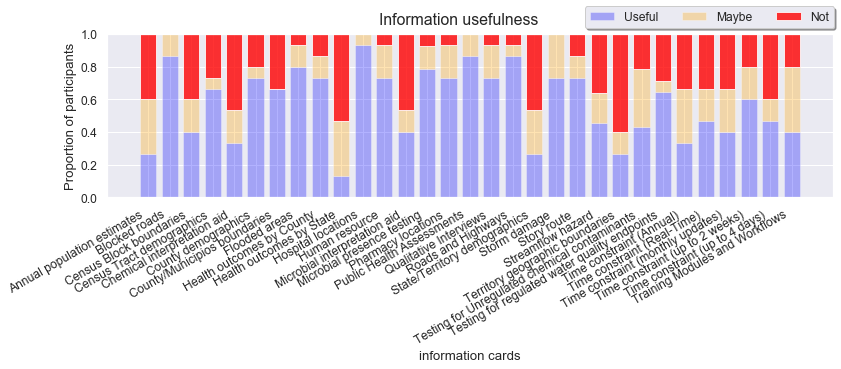

In [11]:
# select the core 31 cards
cf = CardFraction.loc[core31,:]
r = ['*'+each if each in missingsorts else each for each in cf.index.tolist()]
cf.set_index([r])

# set plot dimensions
sb.set(font_scale=1.1)
fig = plt.figure(figsize=(13,3))
barWidth=0.75

# Create Useful, Maybe useful, and Not useful stacked bars
plt.bar(cf.index, cf.Useful, color='blue', width=barWidth, alpha=0.3)
plt.bar(cf.index, cf.Maybe, bottom=np.array(cf.Useful), color='orange', width=barWidth, alpha=0.3)
plt.bar(cf.index, cf.Not, bottom=np.array(cf.Maybe+cf.Useful), color='red', width=barWidth, alpha=0.8)

# Custom axes
plt.xticks(rotation=30, ha='right')
plt.xlabel("information cards")
plt.ylabel("Proportion of participants")

# set plot legend
plt.legend(['Useful','Maybe','Not'], bbox_to_anchor=(0.65, 1.), ncol=3, fancybox=True, shadow=True)
plt.suptitle('Information usefulness')
plt.show()

Let's sort the information card order according to the Useful, Maybe, and Not Useful in descending order. We can input the sorting priorities to rearrange the data visualization.

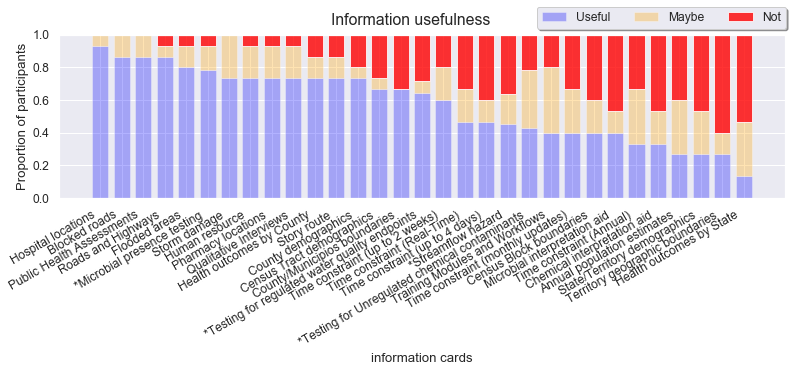

In [12]:
# select the core 31 cards
cf = CardFraction.loc[core31,:].sort_values(['Useful','Maybe','Not'], ascending=False)
r = ['*'+each if each in missingsorts else each for each in cf.index.tolist()]
cf = cf.set_index([r])

# set plot dimensions
sb.set(font_scale=1.1)
fig = plt.figure(figsize=(13,3))
barWidth=0.75

# Create Useful, Maybe useful, and Not useful stacked bars
plt.bar(cf.index, cf.Useful, color='blue', width=barWidth, alpha=0.3)
plt.bar(cf.index, cf.Maybe, bottom=np.array(cf.Useful), color='orange', width=barWidth, alpha=0.3)
plt.bar(cf.index, cf.Not, bottom=np.array(cf.Maybe+cf.Useful), color='red', width=barWidth, alpha=0.8)

# Custom axes
plt.xticks(rotation=30, ha='right')
plt.xlabel("information cards")
plt.ylabel("Proportion of participants")

# set plot legend
plt.legend(['Useful','Maybe','Not'], bbox_to_anchor=(0.65, 1.), ncol=3, fancybox=True, shadow=True)
plt.suptitle('Information usefulness')
plt.savefig(os.path.join(output,'CardUsefulness_Fractions.png'), dpi=300, bbox_inches='tight')
plt.show()

- ### Compute the correlation distance based on the perceived usefulness scores

Although we could observe individual information cards and patterns based on the sort preference, let's use Pearson's correlation to consider the similarities between information cards based on information usefulness ratings as the range of features.

The correlation values seemed to range from 0 to 1. **Time constraint (Annual)** seems to have **NaN**. This is due to the lack of variation between usefulness ratings. **NaN** values will obstruct the methods of heirarchical and kmeans clustering algorithms. Let's exclude **Time constraint (Annual)** in order to proceed in cluster analysis. 

In [13]:
# extract the core 31 information cards and drop the 'Addition' and 'All' columns.
ic = CTdis.loc[core31,:].drop(['Addition','All'], axis=1)

# modify information card names to add asterisk to select information cards
mod_name = ['*'+each if each in missingsorts else each for each in ic.index.tolist()]
ic = ic.set_index([mod_name])

# compute the pairwise Pearsons' correlation coefficients for information card in the 
ic_corr = ic.T.corr()
ic_corr

,Annual population estimates,Blocked roads,Census Block boundaries,Census Tract demographics,Chemical interpretation aid,County demographics,County/Municipios boundaries,Flooded areas,Health outcomes by County,Health outcomes by State,...,*Streamflow hazard,Territory geographic boundaries,*Testing for Unregulated chemical contaminants,*Testing for regulated water quality endpoints,Time constraint (Annual),Time constraint (Real-Time),Time constraint (monthly updates),Time constraint (up to 2 weeks),Time constraint (up to 4 days),Training Modules and Workflows
Annual population estimates,1.000000,-0.928571,0.000000,-0.654654,0.500000,-0.755929,-0.500000,-0.904194,-0.866025,1.000000,...,-0.327327,0.693375,-0.981981,-0.618590,NaN,-0.500000,-0.500000,-0.866025,-0.188982,-0.866025
Blocked roads,-0.928571,1.000000,0.371154,0.888459,-0.142857,0.944911,0.785714,0.998137,0.989743,-0.928571,...,0.654654,-0.376404,0.841698,0.866025,NaN,0.785714,0.785714,0.989743,0.539949,0.618590
Census Block boundaries,0.000000,0.371154,1.000000,0.755929,0.866025,0.654654,0.866025,0.427121,0.500000,0.000000,...,0.944911,0.720577,-0.188982,0.785714,NaN,0.866025,0.866025,0.500000,0.981981,-0.500000
Census Tract demographics,-0.654654,0.888459,0.755929,1.000000,0.327327,0.989743,0.981981,0.914807,0.944911,-0.654654,...,0.928571,0.090784,0.500000,0.998906,NaN,0.981981,0.981981,0.944911,0.866025,0.188982
Chemical interpretation aid,0.500000,-0.142857,0.866025,0.327327,1.000000,0.188982,0.500000,-0.082199,0.000000,0.500000,...,0.654654,0.970725,-0.654654,0.371154,NaN,0.500000,0.500000,0.000000,0.755929,-0.866025
County demographics,-0.755929,0.944911,0.654654,0.989743,0.188982,1.000000,0.944911,0.963123,0.981981,-0.755929,...,0.866025,-0.052414,0.618590,0.981981,NaN,0.944911,0.944911,0.981981,0.785714,0.327327
County/Municipios boundaries,-0.500000,0.785714,0.866025,0.981981,0.500000,0.944911,1.000000,0.821995,0.866025,-0.500000,...,0.981981,0.277350,0.327327,0.989743,NaN,1.000000,1.000000,0.866025,0.944911,0.000000
Flooded areas,-0.904194,0.998137,0.427121,0.914807,-0.082199,0.963123,0.821995,1.000000,0.996616,-0.904194,...,0.699559,-0.319173,0.807183,0.894920,NaN,0.821995,0.821995,0.996616,0.590301,0.569495
Health outcomes by County,-0.866025,0.989743,0.500000,0.944911,0.000000,0.981981,0.866025,0.996616,1.000000,-0.866025,...,0.755929,-0.240192,0.755929,0.928571,NaN,0.866025,0.866025,1.000000,0.654654,0.500000
Health outcomes by State,1.000000,-0.928571,0.000000,-0.654654,0.500000,-0.755929,-0.500000,-0.904194,-0.866025,1.000000,...,-0.327327,0.693375,-0.981981,-0.618590,NaN,-0.500000,-0.500000,-0.866025,-0.188982,-0.866025


In [14]:
ic.loc[['Time constraint (Annual) ']]

Usefulness,Maybe,Not,Useful
Time constraint (Annual),5,5,5


In [15]:
# remove 'Time constraint (Annual) ' from the correlation matrix
ic_corr = ic_corr.drop('Time constraint (Annual) ', axis=1).drop('Time constraint (Annual) ', axis=0)

# remove 'Time constraint (Annual) ' from the modified name list
mod_name.remove('Time constraint (Annual) ')

# remove 'Time constraint (Annual) ' from cf, the object used for the stackbar plot
cf = cf.drop('Time constraint (Annual) ', axis=0)

- ### Determine the number of clusters for perceived usefulness scores

To determine how many clusters to look for, we can use kmeans clustering to find the "elbow" for the optimal number of clusters.

On examination, the elbow appears to be at **k=6 clusters**.

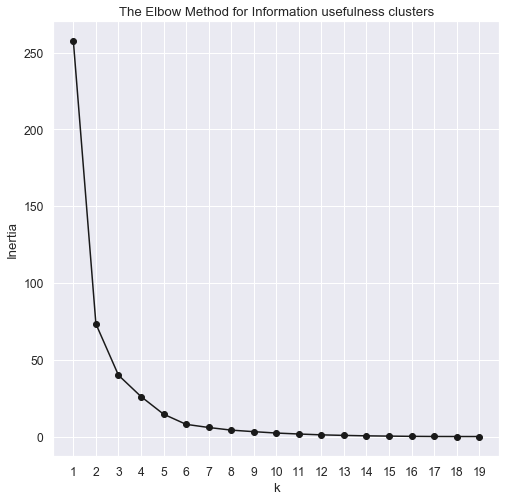

In [16]:
""" Compute the Elbow for Information Usefulness results """
# set seed
np.random.seed(5)

# k means determine k
elbow = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(ic_corr)
    kmeanModel.fit(ic_corr)
    elbow.append(kmeanModel.inertia_)
    
# Plot the elbow
fig = plt.figure(figsize=(8,8))
plt.plot(K, elbow, 'ko-')
plt.xlabel('k')
plt.xticks(K, labels=[str(k) for k in K])
plt.ylabel('Inertia')
plt.title('The Elbow Method for Information usefulness clusters')

plt.savefig(os.path.join(output,'InfoUse_elbow.png'), tight=True)

- ### Cluster the information cards based on correlation distance

Let's cluster the correlation values using Euclidean distance and hierarchical clustering. To define the clusters based on minimum variation in intracluster dissimilarity, we can use Ward method and cut the dendrograms to k=6 clusters.

The correlation heatmap is shown as a mirror, where rows and columns are the reflected order of information cards. Viewing the diagonal values, the k=6 clusters separate very clearly, though there appears to be strong intercluster correlations. The bottom-most cluster appears to be the most useful information cards, the top-most is the least useful information cards.

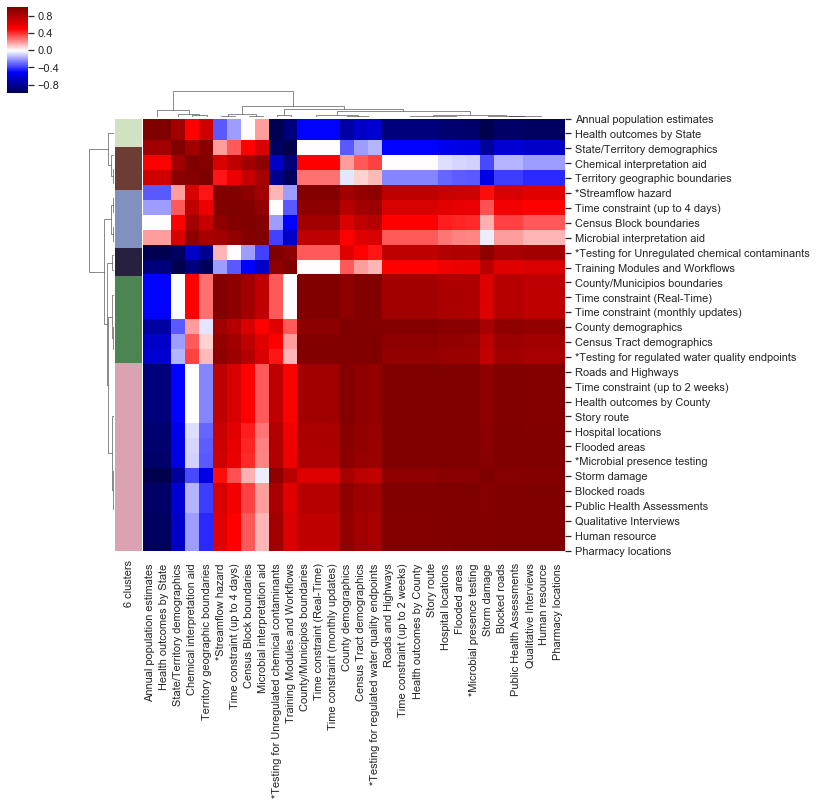

In [17]:
# cut dendrogram into n clusters
Z = ward(ic_corr)
cutree = cut_tree(Z, n_clusters=[6])

# convert to clusters id column vector
ic_df = pd.DataFrame({'clusters':pd.Series(map(lambda x: x[0], cutree))}).set_index(ic_corr.index)

# convert clusterid to cubehelix colors
lut = dict(zip(set(ic_df['clusters']), sb.cubehelix_palette(len(set(ic_df['clusters'])), start=2.1, rot=2.2)))
ic_df['6 clusters'] = ic_df['clusters'].map(lut)

# plot the heatmap in a 10x10 axis
# set center to 0, so that blue-white-red is negative-neutral-positive correlation
sb.set(font_scale=1.0)
s11 = sb.clustermap(ic_corr, 
                    method='ward', 
                    metric='Euclidean', 
                    cmap='seismic', 
                    figsize=(10,10), 
                    row_colors=ic_df['6 clusters'], 
                    center=0, 
                    row_cluster=True, col_cluster=True, 
                    z_score=None, standard_scale=None, cbar_kws=None, row_linkage=None, col_linkage=None, col_colors=None, mask=None)

# Adjust the dendrogram trees to lower the column height and row width
col = s11.ax_col_dendrogram.get_position()
s11.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height*0.25]) # multiplier to lower the column tree
row = s11.ax_row_dendrogram.get_position()
s11.ax_row_dendrogram.set_position([row.x0+(row.width*0.75), row.y0, row.width*0.25, row.height]) # multipliers to narrow in row tree 

# save the correlation plot
plt.savefig(os.path.join(output,'CardConcept_correlation.png'), bbox_inches='tight', dpi=300)

- ### Combine the perceived usefulness scores stacked barchart with the clustergram

Now that we have seen the perceived usefulness scores and the cluster order from the correlation heatmap, let's combine them to understand the clusters among perceived usefulness scores. To do this, let's extract the cluster order from the heatmap object, randomly named **s11**. Next, use the cluster order to change the order of perceived usefulness scores, then render the barchart. After that, let's visualize the dendrogram as it relates to the clusters and add font color to make the clusters visually apparent.

We can see from the resulting visual where the most useful information cards clustered and what information types related with them. Remember, these clusters generally reflect the diagonals in the correlation heatmap, where there were various indications of intracluster correlations. The least useful information cards clustered at bottom. 

While we may speculate where **Time constraint (Annual)** may have clustered, there appear to be relationships through correlation as seen in the correlation heatmap that extend beyond any single usefulness rating. In future studies, we may need more samples to detect variability that is meaningful so as to include all information cards in the analysis.

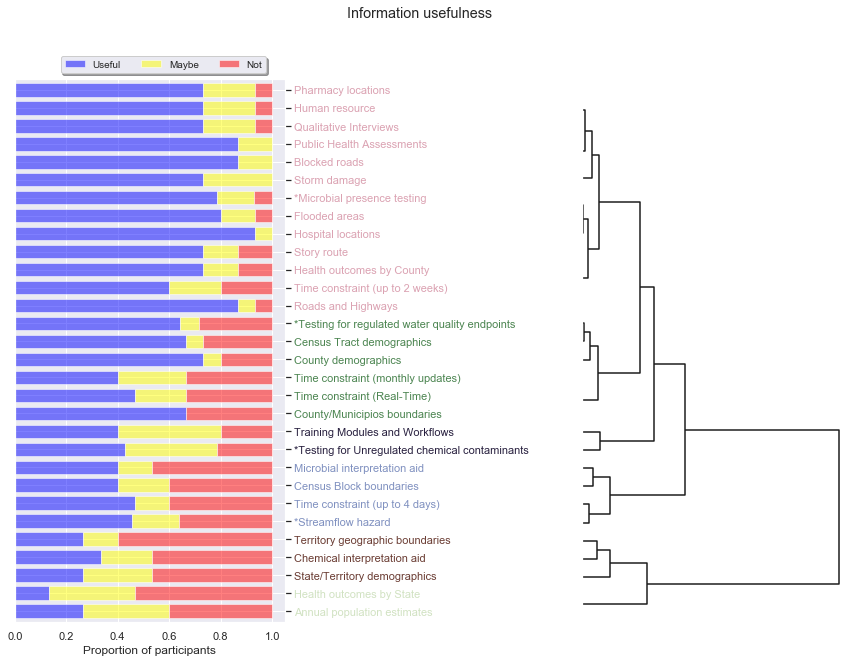

In [18]:
# set figure and subplots
fig, ax1 = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(15,10), gridspec_kw={'wspace': 1.1})
sb.set(font_scale=1.0)
ax1[1].set_facecolor('white')
plt.suptitle('Information usefulness')


"""
1. Extract cluster order to change barchart order
"""
# extract order of labels from the s11 heatmap xaxis
# s11 is a seaborn.matrix.ClusterGrid; use attributes of this class
cluster_order = [label.get_text() for label in s11.ax_heatmap.xaxis.get_majorticklabels()]
cf = cf.loc[cluster_order]


"""
2. Create barchart (left side)
"""
# select the information cards used in the correlation matrix
cf[["Useful","Maybe","Not"]].plot(kind='barh', ax=ax1[0], stacked=True, legend=True, 
                                  width=.75, alpha=0.5, color=['blue','yellow','red'], edgecolor='white')
ax1[0].set_xlabel('Proportion of participants')
ax1[0].legend(loc='upper right', bbox_to_anchor=(.95, 1.05), fancybox=True, shadow=True, ncol=3, fontsize='small')

# Move card labels to the right side rows, beside the dendrogram
ax1[0].yaxis.set_label_position("right")
ax1[0].yaxis.tick_right()


"""
3. Create dendrogram (right side)
"""
dendrogram(linkage(y=ic_corr, method='ward', metric='euclidean'),
           ax=ax1[1], orientation='right', no_labels=True, link_color_func=lambda x: 'k', above_threshold_color='k')
ax1[1].set_xticklabels([''])
ax1[1].set_yticklabels([''])


"""
4. Color the barchart by cluster membership
"""
ylabels = ax1[0].get_ymajorticklabels()
for ind, y_labels in enumerate(ylabels):
    # remove asterisk
    tmp=y_labels.get_text()
    y_labels.set_color(ic_df.loc[tmp]['6 clusters'])


# save figure    
plt.savefig(os.path.join(output,'info_useful_clustergram.png'), bbox_tight=True, dpi=300)

# 4. Examine patterns in Use-case referencing

Now, let's examine the Use-cases discussed. 

First, let's binarize the matrices to compare discussions across participants. The **matrices_to_UCTable** function will automate the reading and assign 1 to indicate discussion. We can denote **UCTable** to retain the summary output.

In [19]:
# generate the Usecase Table

def matrices_to_UCTable(listOfMatrices):
    for eachmatrix in listOfMatrices:

        # extract PID
        PID = eachmatrix.ParticipantID.unique()[0]

        # remove extra columns
        PID_ind = eachmatrix.drop(['ParticipantID','CardCode','CardConcept','CardUsefulness','CardUsefulnessComment'], axis=1).T.reset_index(level=2).drop('UsecaseNotes', axis=1)

        # generate default use-case weight (presence = 1)
        PID_ind[PID] = 1

        # extract dataframe for merging
        PID_table = PID_ind.loc[:,[PID]]
        if 'UCTable' not in locals():
            UCTable = PID_table
        else:
            UCTable = UCTable.merge(PID_table, left_index=True, right_index=True, how='outer')
        
    # remove duplicated rows
    return(UCTable.loc[~UCTable.index.duplicated(),:])

# 
UCTable = matrices_to_UCTable(listOfMatrices)
UCTable

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


,,P01,P02,P04,P05,P06,P07,P08,P11,P12,P13,P16,P17,P18,P19,P20
UsecaseCode,UsecaseDescr,,,,,,,,,,,,,,,
U1,Assess access to care and treatments,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN
U10,Locate community place references,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U11,Establish a disease surveillance system,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN
U12,Translate information between high and low resolution areas,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U14,Organize acute disaster response at the local scale,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U87,Identify transport needs for vulnerable populations,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
U88,Prepare food-water-shelter locations,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
U89,Assess access and use of resources,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- ### Count number of participants that discussed each use-case 

We can compute row-wise counts of Participant IDs. This variable can be sorted to determine what was most and least commonly discussed.

There were 79 use-cases. The participants discussed anywhere between 5 to 29 use-cases. **Assess access to care and treatments** was the most highly discussed information use-case by 9 participants. The matrix appears very sparse. There are many single-mention use-cases.

In [20]:
UCTable['count'] = UCTable.loc[:,UCTable.columns.str.contains("P")].sum(axis=1)

UCTable.loc[:,UCTable.columns.str.contains("P")].sum(axis=0)

P01    20.0
P02    16.0
P04    14.0
P05    12.0
P06     8.0
P07    11.0
P08    12.0
P11     6.0
P12     5.0
P13    17.0
P16    29.0
P17    15.0
P18    21.0
P19    12.0
P20    15.0
dtype: float64

In [21]:
UCTable.sort_values('count', ascending=False)

,,P01,P02,P04,P05,P06,P07,P08,P11,P12,P13,P16,P17,P18,P19,P20,count
UsecaseCode,UsecaseDescr,,,,,,,,,,,,,,,,
U1,Assess access to care and treatments,1.0,1.0,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,9.0
U4,Locate and prioritize areas with vulnerable populations,1.0,1.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,8.0
U24,Identify risk factors that will impact people in the area,NaN,1.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,NaN,1.0,1.0,8.0
U5,Coordinate efforts with the administrative governance,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,7.0
U47,Characterize potential harms in the water systems,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,1.0,1.0,1.0,1.0,NaN,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U57,Assess access to information for disaster responders,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
U60,Characterize post-disaster reconstruction over time,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0
U65,Identify wells that need to be decontaminated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0


- ### Calculate the correlation distance between information use-case discussions

Let's repeat the correlation calculations this time using the **UsecaseDescr** and the **Participant ID** variables. There are no **NaN** values within this correlation matrix.

In [22]:
UCdis = UCTable.loc[:,UCTable.columns.str.contains("P")].stack().reset_index().rename(columns={'level_2':'ParticipantID',0:'linkage'})

UCdis_corr = pd.crosstab(UCdis.ParticipantID, UCdis.UsecaseDescr).corr()
UCdis_corr

UsecaseDescr,Assess access and use of resources,Assess access to batteries and backup power,Assess access to care and treatments,Assess access to information for disaster responders,Assess conditions and impacts on the environment,Assess for community cohesiveness and social isolation,Assess for data quality and validity,Assess for individual and family level of preparation,Assess information formatting,Assess the effectiveness of response actions,...,Organize acute disaster response at the local scale,Prepare checklists and tests,Prepare food-water-shelter locations,Prepare for segregation of dead bodies,Prepare hospitals and preposition rescue workers and supplies,Prepare information as GIS layers,Provide just-in-time training,Set up forwarding locations,Translate information between high and low resolution areas,Visualize data and resources relative to the administrative boundaries
UsecaseDescr,,,,,,,,,,,,,,,,,,,,,
Assess access and use of resources,1.000000,-0.104828,-0.327327,-0.071429,-0.161165,-0.071429,-0.071429,0.534522,-0.104828,-0.071429,...,-0.071429,-0.104828,-0.071429,-0.071429,-0.133631,-0.071429,-0.188982,-0.104828,-0.071429,-0.133631
Assess access to batteries and backup power,-0.104828,1.000000,-0.080064,-0.104828,-0.236525,-0.104828,0.681385,-0.196116,-0.153846,-0.104828,...,-0.104828,-0.153846,-0.104828,-0.104828,-0.196116,0.681385,-0.277350,-0.153846,-0.104828,0.294174
Assess access to care and treatments,-0.327327,-0.080064,1.000000,0.218218,-0.123091,-0.327327,0.218218,-0.612372,-0.080064,0.218218,...,0.218218,0.320256,-0.327327,-0.327327,0.068041,-0.327327,-0.288675,0.320256,0.218218,0.408248
Assess access to information for disaster responders,-0.071429,-0.104828,0.218218,1.000000,0.443203,-0.071429,-0.071429,-0.133631,0.681385,-0.071429,...,-0.071429,-0.104828,-0.071429,-0.071429,-0.133631,-0.071429,-0.188982,-0.104828,-0.071429,0.534522
Assess conditions and impacts on the environment,-0.161165,-0.236525,-0.123091,0.443203,1.000000,-0.161165,-0.161165,0.075378,0.650444,-0.161165,...,-0.161165,-0.236525,0.443203,0.443203,0.075378,-0.161165,0.213201,-0.236525,-0.161165,0.075378
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Prepare information as GIS layers,-0.071429,0.681385,-0.327327,-0.071429,-0.161165,-0.071429,-0.071429,-0.133631,-0.104828,-0.071429,...,-0.071429,-0.104828,-0.071429,-0.071429,-0.133631,1.000000,-0.188982,-0.104828,-0.071429,-0.133631
Provide just-in-time training,-0.188982,-0.277350,-0.288675,-0.188982,0.213201,-0.188982,-0.188982,0.000000,0.138675,0.377964,...,0.377964,0.138675,0.377964,0.377964,0.353553,-0.188982,1.000000,0.554700,0.377964,-0.353553
Set up forwarding locations,-0.104828,-0.153846,0.320256,-0.104828,-0.236525,-0.104828,-0.104828,-0.196116,-0.153846,0.681385,...,0.681385,0.423077,-0.104828,-0.104828,0.294174,-0.104828,0.554700,1.000000,0.681385,-0.196116


In [23]:
UCdis_corr[UCdis_corr.isna().sum(axis=0)>0]

UsecaseDescr,Assess access and use of resources,Assess access to batteries and backup power,Assess access to care and treatments,Assess access to information for disaster responders,Assess conditions and impacts on the environment,Assess for community cohesiveness and social isolation,Assess for data quality and validity,Assess for individual and family level of preparation,Assess information formatting,Assess the effectiveness of response actions,...,Organize acute disaster response at the local scale,Prepare checklists and tests,Prepare food-water-shelter locations,Prepare for segregation of dead bodies,Prepare hospitals and preposition rescue workers and supplies,Prepare information as GIS layers,Provide just-in-time training,Set up forwarding locations,Translate information between high and low resolution areas,Visualize data and resources relative to the administrative boundaries
UsecaseDescr,,,,,,,,,,,,,,,,,,,,,


In [24]:
""" the only instance use of 'linkage' """

ucd_c = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
ucd_c.fit_predict(UCdis_corr)

Z = linkage(UCdis_corr, 'ward')

- ### Determine the number of clusters for the information use-case discussions

We repeat the kmeans clustering for the 'elbow'. Since there are 79 clusters, let's explore up to k=50.

Visual inspection can determine that an elbow appears around **k=8**. However, this is a very round elbow. Additional *k* clusters have an effect to reduce the explained innertia. It is not clear that k=8 provides enough explanation for the amount of variability remaining. It could be at k=15.

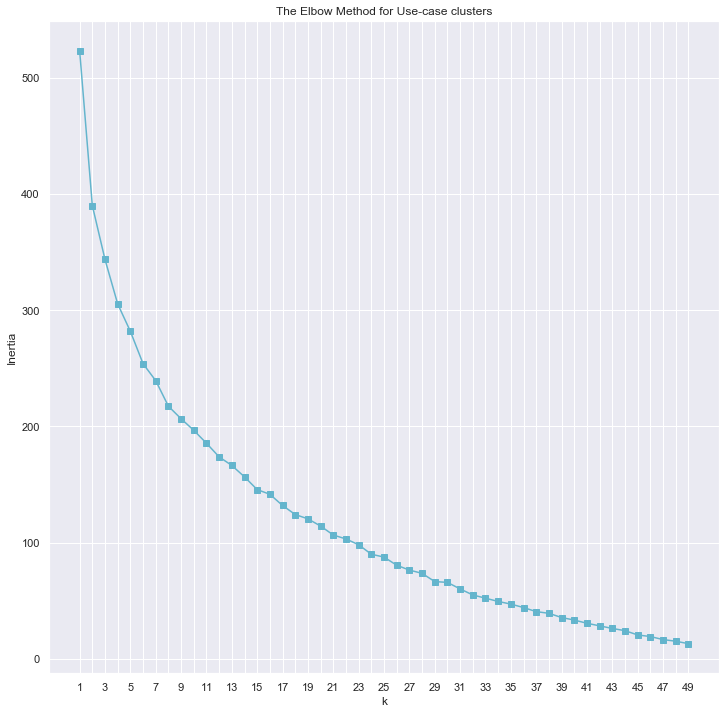

In [25]:
np.random.seed(5)

# k means determine k
elbow = []
K = range(1,50)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(UCdis_corr)
    kmeanModel.fit(UCdis_corr)
    elbow.append(kmeanModel.inertia_)
    
# Plot the elbow
fig = plt.figure(figsize=(12,12))
sb.set(font_scale=1.)
plt.plot(K, elbow, 'cs-')
plt.xlabel('k')
plt.xticks(K, labels=[str(k) if k % 2 !=0 else '' for k in K])
plt.ylabel('Inertia')
plt.title('The Elbow Method for Use-case clusters')
plt.savefig(os.path.join(output,'Usecase_elbow.png'), bbox_tight=True, dpi=300)

- ### Clusters the use-case discussions

Using the same protocols that were used for the perceived usefulness scores, let's determine the number of clusters by correlation heatmap. We can investigate the k=8 and k=15 approach using separate row-color features.

The heatmap appears to have several noteworthy clusters based on the intracluster correlation along the diagonal but there are many intercluster correlation effects. Between the k=8 or k=15, k=8 appears to explain enough of the major clusters when we consider the branching of the tree. K=15 provides more resolution needed to examine the clusters at the bottom of the plot. There are only 15 participants and it was visually a sparse matrix, so the optimal number of clusters here is ambiguous.

For one thing, **Assess access to care and treatment** is in the bottom-left most cluster. **Locate and prioritize areas with vulnerable populations** was in the fourth-from-the-top purple cluster if using the k=8 row colors. The top-left two clusters appear to be densely correlated with each other, whereas the bottom-left most cluster has more intercluster correlations.

In [26]:
# cluster and cut the tree using Ward method
Z = ward(UCdis_corr)
cutree = cut_tree(Z, n_clusters=[8, 15])

# convert clusterid to color
ucd_df1 = pd.DataFrame({'cluster ':pd.Series(map(lambda x: x[0], cutree))}).set_index(UCdis_corr.index)
lut = dict(zip(set(ucd_df1['cluster ']), sb.color_palette('gnuplot2', len(set(ucd_df1['cluster '])))))
ucd_df1['8 clusters'] = ucd_df1['cluster '].map(lut)

ucd_df2 = pd.DataFrame({'cluster ':pd.Series(map(lambda x: x[1], cutree))}).set_index(UCdis_corr.index)
lut = dict(zip(set(ucd_df2['cluster ']), sb.color_palette('Blues', len(set(ucd_df2['cluster '])))))
ucd_df2['15 clusters'] = ucd_df2['cluster '].map(lut)

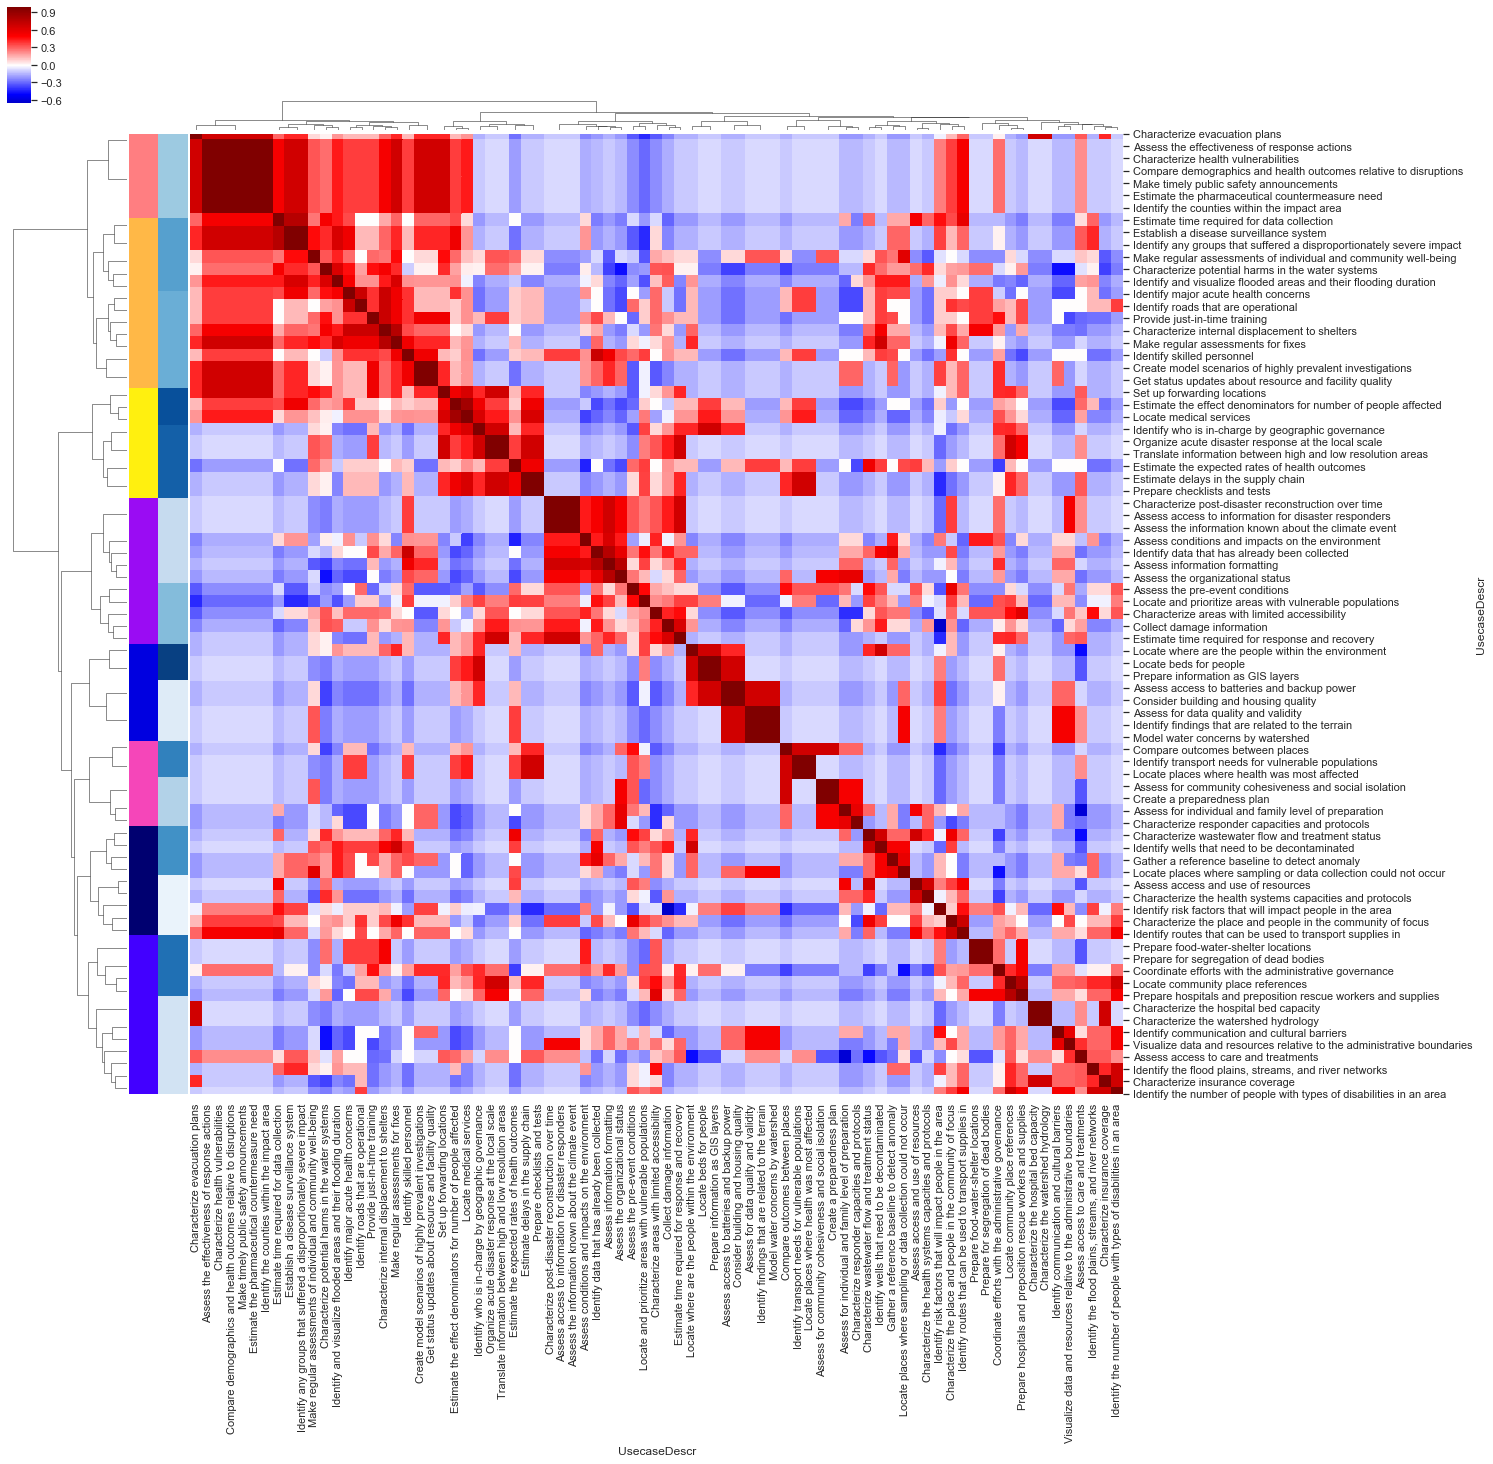

In [27]:
# plot the heatmap
sb.set(font_scale=1.)
s12 = sb.clustermap(UCdis_corr, 
                    method='ward', 
                    metric='euclidean',
                    cmap='seismic',
                    figsize=(20,20), 
                    row_colors=[ucd_df1['8 clusters'], ucd_df2['15 clusters']],
                    center=0,
                    row_cluster=True, col_cluster=True, 
                    cbar_kws=None, standard_scale=None, row_linkage=None, col_linkage=None, col_colors=None, mask=None)

# adjust dendrogram height
col = s12.ax_col_dendrogram.get_position()
s12.ax_col_dendrogram.set_position([col.x0, col.y0, col.width, col.height*0.25])

# save the correlation plot
plt.savefig(os.path.join(output,'Usecase_correlation.png'), dpi=300, bbox_inches='tight')

- ### Extract the top 15 information use-cases discussed

Based on the count of discussions, let's extract the use-case names at the head 15 of the sorted table. The function **matrices_to_mastermat** can transform the list of card sort matrices to a long-table mapping the **participant ID**, **information cards**, and their **information use-cases**

On average, participants discussed 14 use-cases (standard deviation of 6). The minimum and maximum number of use-cases discussed across sessions was 5 and 29, respectively. 

In [28]:
# top 15 use-cases across participants
topUC = UCTable.sort_values('count', ascending=False)
topUC[:15].iloc[:,-1]

UsecaseCode  UsecaseDescr                                                   
U1           Assess access to care and treatments                               9.0
U4           Locate and prioritize areas with vulnerable populations            8.0
U24          Identify risk factors that will impact people in the area          8.0
U5           Coordinate efforts with the administrative governance              7.0
U47          Characterize potential harms in the water systems                  7.0
U16          Make regular assessments of individual and community well-being    6.0
U3           Characterize areas with limited accessibility                      6.0
U59          Assess the pre-event conditions                                    6.0
U15          Provide just-in-time training                                      5.0
U66          Identify major acute health concerns                               5.0
U18          Estimate the effect denominators for number of people affected     5.0

In [29]:
# mean, standard deviation, min, and max of the total number of use-cases mentioned across participants
UCTable.drop('count',axis=1).sum(axis=0).describe()

count    15.000000
mean     14.200000
std       6.131884
min       5.000000
25%      11.500000
50%      14.000000
75%      16.500000
max      29.000000
dtype: float64

In [30]:
def matrices_to_mastermat(listOfMatrices):
    for eachmat in listOfMatrices:

        # melt and extract usefulness mappings per matrix
        t_p01 = eachmat.melt(id_vars=['ParticipantID','CardCode','CardConcept'])
        t_p01 = t_p01.loc[(t_p01.value==1) | 
                          (t_p01.UsecaseCode.apply(lambda x: x.startswith('U')) & t_p01.value.apply(lambda x: pd.isnull(x))),:]

        # append to master matrix
        if 'mastermat' not in locals():
            mastermat = t_p01
        else:
            mastermat = pd.concat([mastermat, t_p01], join='outer')

    # remove duplicated rows
    mastermat = mastermat.reset_index(drop=True)
    return(mastermat)

M1 = matrices_to_mastermat(listOfMatrices)
M1.head(15)

,ParticipantID,CardCode,CardConcept,UsecaseCode,UsecaseDescr,UsecaseNotes,value
0,P01,C1,Story route,U1,Assess access to care and treatments,,NaN
1,P01,C2,Storm damage,U1,Assess access to care and treatments,,NaN
2,P01,C3,Hospital locations,U1,Assess access to care and treatments,,1
3,P01,C4,Pharmacy locations,U1,Assess access to care and treatments,,1
4,P01,C5,Roads and Highways,U1,Assess access to care and treatments,,NaN
5,P01,C6,Blocked roads,U1,Assess access to care and treatments,,NaN
6,P01,C7,Flooded areas,U1,Assess access to care and treatments,,NaN
7,P01,C8,Streamflow hazard,U1,Assess access to care and treatments,,NaN
8,P01,C9,Microbial presence testing,U1,Assess access to care and treatments,,NaN
9,P01,C10,Testing for regulated water quality endpoints,U1,Assess access to care and treatments,,NaN


In [31]:
# Let's drop rows where value is NaN. These were non-associations.
M1 = M1.loc[M1.value.dropna().index]
M1.value = M1.value.astype(int)

Let's examine the Nominated information relative to the information use-cases discussed with them.



In [32]:
Addition_usecases = M1.loc[M1.CardConcept.isin(Additions)].pivot_table(index='UsecaseDescr',
                                                                       columns='CardConcept', 
                                                                       values='value').fillna(0)*100
Addition_usecases.head()

CardConcept,Allied healthcare providers,Building and housing quality,Community boundaries,Community cohesiveness,Dialysis clinics,Disposal plan for dead bodies,"Doctor's office, clinics, and ambulatory surgery centers",Econometric surveys and databases,Electronic health record information,Evacuation plans,...,Public utilities,Responder standard operating protocol,Shelters and feeding stations,Supply chain of emergency supplies,Tribal governments,Vulnerable populations,Wastewater treatment and Sanitation,Water Infrastructure,Watershed boundaries,Weather information
UsecaseDescr,,,,,,,,,,,,,,,,,,,,,
Assess access and use of resources,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
Assess access to batteries and backup power,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Assess access to care and treatments,100.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Assess access to information for disaster responders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Assess for community cohesiveness and social isolation,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# find use-cases related to a card
M1.loc[M1.CardConcept.apply(lambda x: x.startswith('Neighbor'))]

,ParticipantID,CardCode,CardConcept,UsecaseCode,UsecaseDescr,UsecaseNotes,value
3459,P13,C46,Neighborhood information,U55,Characterize the place and people in the commu...,,1
3555,P13,C46,Neighborhood information,U57,Assess access to information for disaster resp...,,1
3651,P13,C46,Neighborhood information,U58,Assess information formatting,,1
3779,P13,C46,Neighborhood information,U5,Coordinate efforts with the administrative gov...,"""a lot of decision makers don’t use census tra...",1
3811,P13,C46,Neighborhood information,U30,Visualize data and resources relative to the a...,,1


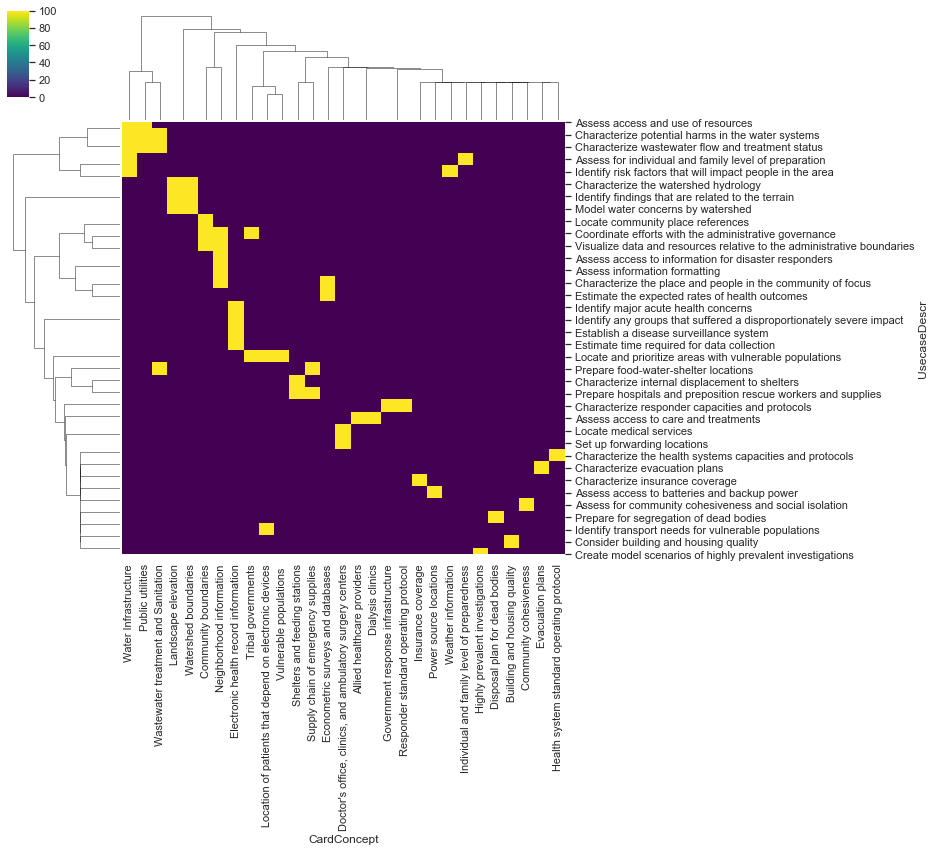

In [34]:
sb.clustermap(Addition_usecases, method='ward', metric='euclidean', cmap='viridis')